In [1]:
# importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [33]:
# Load Airbnb data
df = pd.read_excel("Airbnb_data.xlsx")
df.head()

id  log_price property_type        room_type  \
0   6901257   5.010635     Apartment  Entire home/apt   
1   6304928   5.129899     Apartment  Entire home/apt   
2   7919400   4.976734     Apartment  Entire home/apt   
3  13418779   6.620073         House  Entire home/apt   
4   3808709   4.744932     Apartment  Entire home/apt   

                                           amenities  accommodates  bathrooms  \
0  {"Wireless Internet","Air conditioning",Kitche...             3        1.0   
1  {"Wireless Internet","Air conditioning",Kitche...             7        1.0   
2  {TV,"Cable TV","Wireless Internet","Air condit...             5        1.0   
3  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             4        1.0   
4  {TV,Internet,"Wireless Internet","Air conditio...             2        1.0   

   bed_type cancellation_policy  cleaning_fee  ...   latitude   longitude  \
0  Real Bed              strict          True  ...  40.696524  -73.991617   
1  Real Bed              strict          True  ...  40.766115  -73.989040   
2  Real Bed            moderate          True  ...  40.808110  -73.943756   
3  Real Bed            flexible          True  ...  37.772004 -122.431619   
4  Real Bed            moderate          True  ...  38.925627  -77.034596   

                                       name     neighbourhood  \
0            Beautiful brownstone 1-bedroom  Brooklyn Heights   
1  Superb 3BR Apt Located Near Times Square    Hell's Kitchen   
2                          The Garden Oasis            Harlem   
3        Beautiful Flat in the Heart of SF!      Lower Haight   
4                Great studio in midtown DC  Columbia Heights   

  number_of_reviews  review_scores_rating  \
0                 2                 100.0   
1                 6                  93.0   
2                10                  92.0   
3                 0                   NaN   
4                 4                  40.0   

                                       thumbnail_url zipcode bedrooms  beds  
0  https://a0.muscache.com/im/pictures/6d7cbbf7-c...   11201      1.0   1.0  
1  https://a0.muscache.com/im/pictures/348a55fe-4...   10019      3.0   3.0  
2  https://a0.muscache.com/im/pictures/6fae5362-9...   10027      1.0   3.0  
3  https://a0.muscache.com/im/pictures/72208dad-9...   94117      2.0   2.0  
4                                                NaN   20009      0.0   1.0  

[5 rows x 29 columns]

##  1. Data Exploration and Preprocessing

In [34]:
df['host_response_rate'] = df['host_response_rate'].astype(str).str.replace('%', '')
df['host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce')


In [35]:
bool_cols = ['cleaning_fee', 'instant_bookable', 'host_has_profile_pic', 'host_identity_verified']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: 1 if x in ['t', True] else 0)


In [36]:
df['num_amenities'] = df['amenities'].apply(lambda x: len(str(x).split(',')))
df.drop('amenities', axis=1, inplace=True)


In [37]:
drop_cols = ['id', 'name', 'description', 'thumbnail_url', 'first_review', 'last_review', 'host_since']
for col in drop_cols:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)


In [38]:
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))


In [39]:
df = df.fillna(df.median(numeric_only=True))

## 2. Model Development 

In [40]:
X = df.drop('log_price', axis=1)
y = df['log_price']


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [42]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Random Forest
rf = RandomForestRegressor(random_state=1)
rf.fit(X_train, y_train)

# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=1)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [43]:
lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)
xgb_pred = xgb_model.predict(X_test)


 ## 3. Model Evaluation

In [44]:
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\nModel: {name}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

evaluate_model("Linear Regression", y_test, lr_pred)
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("XGBoost", y_test, xgb_pred)



Model: Linear Regression
RMSE: 0.4923
MAE : 0.3663
R²  : 0.5341

Model: Random Forest
RMSE: 0.3945
MAE : 0.2833
R²  : 0.7009

Model: XGBoost
RMSE: 0.3892
MAE : 0.2816
R²  : 0.7089


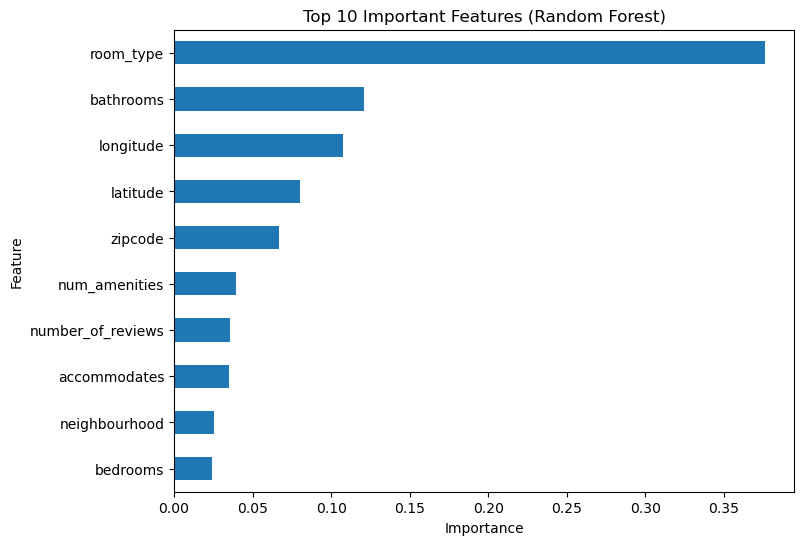

In [45]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_10 = importances.sort_values().tail(10)

top_10.plot(kind='barh', figsize=(8, 6))
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## 4. Final Report and Presentation

In [ ]:
Video Link: https://drive.google.com/file/d/1rrzNZmdE-COCm0K33aV12empMI1Ei9bi/view?usp=sharing